<a href="https://colab.research.google.com/github/SrijaaimeenakshiM/Cyclone_prediction/blob/main/cyclone_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
#import the dataset
df=pd.read_csv("data.csv")
df.head(),df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20167 entries, 0 to 20166
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   No. of Cycl  20167 non-null  int64  
 1   Time         20167 non-null  object 
 2   Speed        20167 non-null  float64
 3   Lat          20167 non-null  float64
 4   Lon          20167 non-null  float64
dtypes: float64(3), int64(1), object(1)
memory usage: 787.9+ KB


(   No. of Cycl                 Time  Speed   Lat   Lon
 0            1  1979-11-25 00:00:00   25.0   7.0  86.0
 1            1  1979-11-25 06:00:00   25.0   7.9  85.8
 2            1  1979-11-25 12:00:00   25.0   8.8  85.5
 3            1  1979-11-25 18:00:00   25.0   9.7  85.1
 4            1  1979-11-26 00:00:00   30.0  10.4  84.4,
 None)

In [ ]:
df.isnull().sum()

,0
No. of Cycl,0
Time,0
Speed,1
Lat,0
Lon,0


In [ ]:
df['Speed'] = df['Speed'].fillna(df['Speed'].mean())

In [ ]:
df.isnull().sum()

,0
No. of Cycl,0
Time,0
Speed,0
Lat,0
Lon,0


In [ ]:
df['Time'] = pd.to_datetime(df['Time'])  # Convert Time column to datetime
df['Year']=df['Time'].dt.year
# Sorting data by time
df = df.sort_values(by=['Year','No. of Cycl', 'Time']).reset_index(drop=True)


##Let's visualize

In [ ]:

!pip install basemap

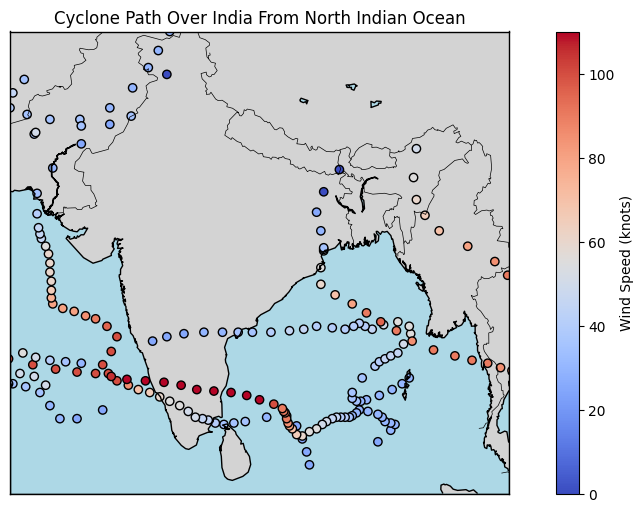

In [ ]:
#Plot the datas in the dataset
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

plt.figure(figsize=(12,6))

# Initialize Basemap centered on India
m = Basemap(projection="merc",
            llcrnrlon=65, urcrnrlon=100,
            llcrnrlat=5, urcrnrlat=35,
            resolution="l")

# Draw map features
m.drawcoastlines()
m.drawcountries()
m.drawmapboundary(fill_color="lightblue")
m.fillcontinents(color="lightgray", lake_color="lightblue")

# Convert lat/lon to map coordinates
x, y = m(df["Lon"][:500].values, df["Lat"][:500].values)

# Scatter plot with cyclone path
sc = m.scatter(x, y, c=df["Speed"][:500], cmap="coolwarm", edgecolors="black")

# Add colorbar
plt.colorbar(sc, label="Wind Speed (knots)")

plt.title("Cyclone Path Over India From North Indian Ocean")
plt.show()


<ipython-input-11-f065a53ef83b>:5: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  yearly_avg_windspeed = df['Speed'].resample('Y').mean()


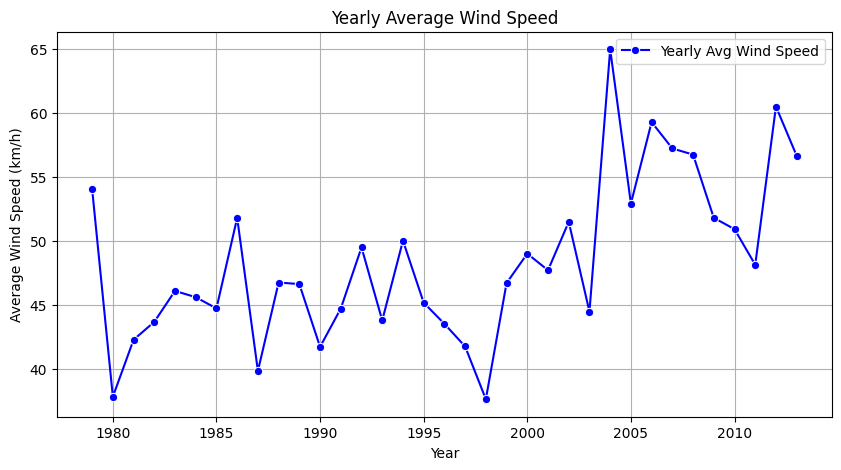

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate yearly average wind speed
yearly_avg_windspeed = df['Speed'].resample('Y').mean()

# Convert index to year format
yearly_avg_windspeed.index = yearly_avg_windspeed.index.year

# Plot yearly average wind speed
plt.figure(figsize=(10, 5))
sns.lineplot(x=yearly_avg_windspeed.index, y=yearly_avg_windspeed.values, marker='o', color='b', label="Yearly Avg Wind Speed")

# Labels and title
plt.xlabel("Year")
plt.ylabel("Average Wind Speed (km/h)")
plt.title("Yearly Average Wind Speed")
plt.grid(True)
plt.legend()

# Show plot
plt.show()


#Normalization

In [ ]:
# Feature selection
features = ['Speed', 'Lat', 'Lon']
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df[features])

df_scaled


array([[0.16666667, 0.16317016, 0.63609467],
       [0.16666667, 0.18414918, 0.63461538],
       [0.16666667, 0.20512821, 0.63239645],
       ...,
       [0.16666667, 0.1958042 , 0.60724852],
       [0.13333333, 0.1958042 , 0.59911243],
       [0.13333333, 0.18414918, 0.59319527]])

#Building our LSTM model

In [ ]:
# Creating sequences for LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

SEQ_LENGTH = 10  # Sequence length for LSTM
X, y = create_sequences(df_scaled, SEQ_LENGTH)

In [ ]:
# Splitting dataset
split = int(0.8 * len(X))
X_train, X_test, y_train, y_test = X[:split], X[split:], y[:split], y[split:]

In [ ]:
# Building LSTM Model
model = Sequential([
    LSTM(50, activation='relu', return_sequences=True, input_shape=(SEQ_LENGTH, X.shape[2])),
    Dropout(0.2),
    LSTM(50, activation='relu'),
    Dropout(0.2),
    Dense(X.shape[2])  # Predicting Speed, Lat, and Lon
])

model.compile(optimizer='adam', loss='mse')

In [ ]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 10, 50)              │          10,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 10, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             153 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 93,461 (365.09 KB)

 Trainable params: 31,153 (121.69 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 62,308 (243.39 KB)

In [ ]:

history=model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))



Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


504/504 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - loss: 0.0351 - val_loss: 0.0044
Epoch 2/20
504/504 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - loss: 0.0087 - val_loss: 0.0036
Epoch 3/20
504/504 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - loss: 0.0067 - val_loss: 0.0032
Epoch 4/20
504/504 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - loss: 0.0058 - val_loss: 0.0026
Epoch 5/20
504/504 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - loss: 0.0051 - val_loss: 0.0023
Epoch 6/20
504/504 ━━━━━━━━━━━━━━━━━━━━ 16s 13ms/step - loss: 0.0047 - val_loss: 0.0023
Epoch 7/20
504/504 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - loss: 0.0042 - val_loss: 0.0024
Epoch 8/20
504/504 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - loss: 0.0039 - val_loss: 0.0020
Epoch 9/20
504/504 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.0039 - val_loss: 0.0020
Epoch 10/20
504/504 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 0.0038 - val_loss: 0.0019
Epoch 11/20
504/504 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 0.0038 - val_loss: 0.0019
Epoch 12/20
504/504 ━━━━━━━━━━━━━━━━━━━━ 8s 1

<Axes: >

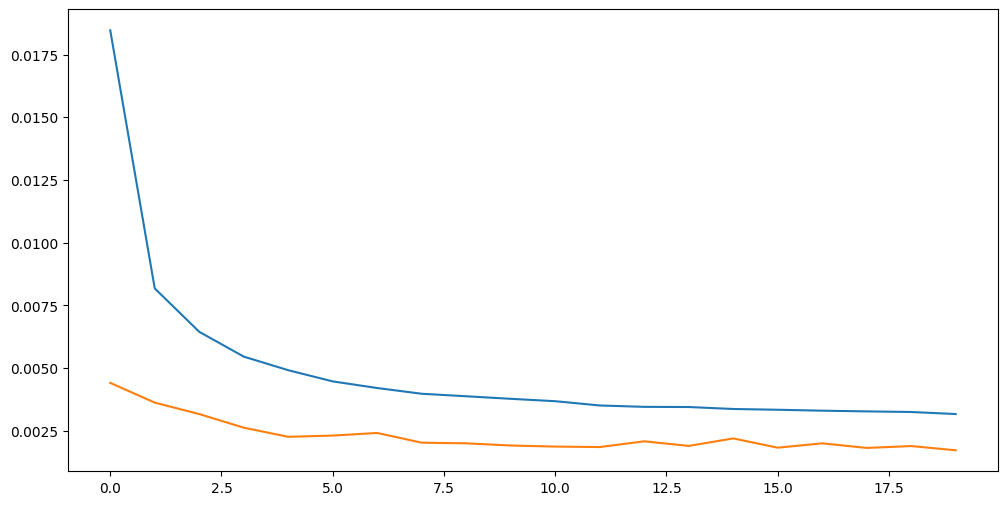

In [ ]:
#Plotting loss curve
plt.figure(figsize=(12, 6))
sns.lineplot(history.history['loss'])
sns.lineplot(history.history['val_loss'])

In [ ]:
y_pred=model.predict(X_test)

126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


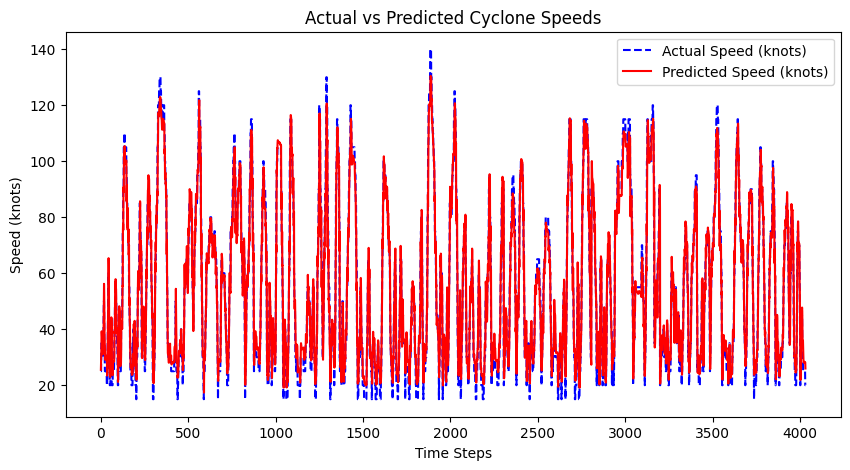

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Convert predictions back to original scale if necessary
y_test_inv = scaler.inverse_transform(y_test)  # Original values
y_pred_inv = scaler.inverse_transform(y_pred)# Predicted values

# Plot actual vs predicted values
plt.figure(figsize=(10, 5))
plt.plot(y_test_inv[:, 0], label="Actual Speed (knots)", linestyle="dashed", color="blue")
plt.plot(y_pred_inv[:, 0], label="Predicted Speed (knots)", linestyle="solid", color="red")
plt.xlabel("Time Steps")
plt.ylabel("Speed (knots)")
plt.title("Actual vs Predicted Cyclone Speeds")
plt.legend()
plt.show()




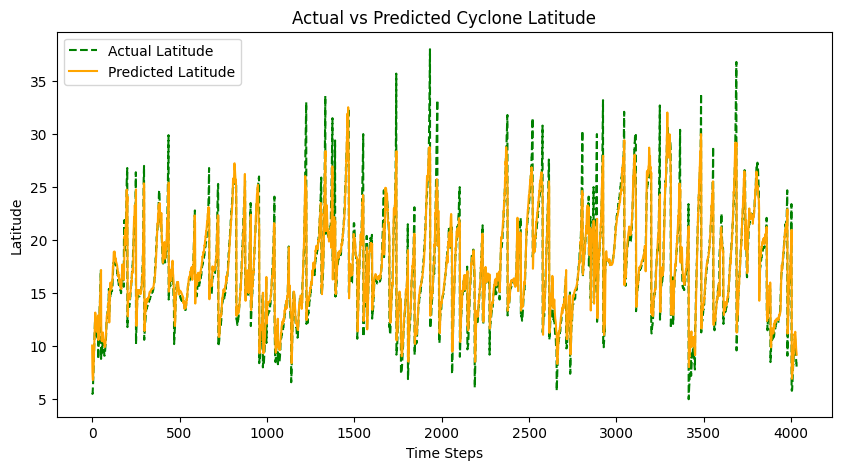

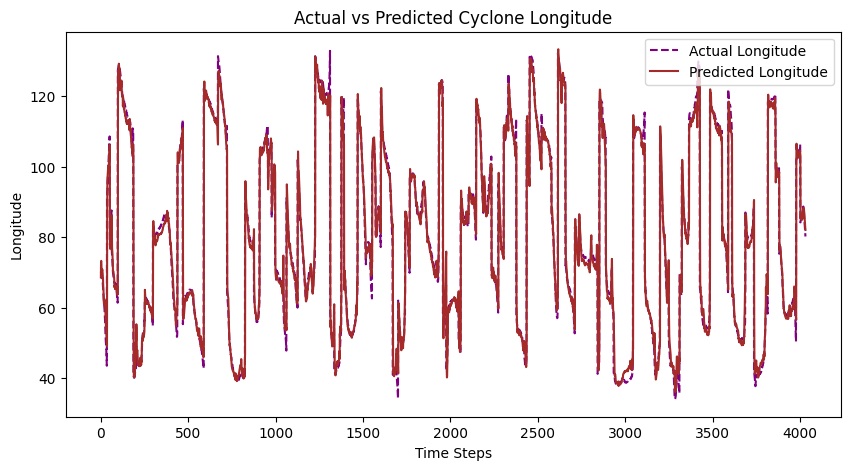

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(y_test_inv[:, 1], label="Actual Latitude", linestyle="dashed", color="green")
plt.plot(y_pred_inv[:, 1], label="Predicted Latitude", linestyle="solid", color="orange")
plt.xlabel("Time Steps")
plt.ylabel("Latitude")
plt.title("Actual vs Predicted Cyclone Latitude")
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(y_test_inv[:, 2], label="Actual Longitude", linestyle="dashed", color="purple")
plt.plot(y_pred_inv[:, 2], label="Predicted Longitude", linestyle="solid", color="brown")
plt.xlabel("Time Steps")
plt.ylabel("Longitude")
plt.title("Actual vs Predicted Cyclone Longitude")
plt.legend()
plt.show()

In [ ]:
import pandas as pd
import folium
import matplotlib.pyplot as plt
from folium.plugins import HeatMap
import matplotlib.colors as mcolors

# Convert y_pred to a DataFrame
y_pred_df = pd.DataFrame(y_pred, columns=['Speed', 'Lat', 'Lon'])  # Ensure correct order

# Ensure required columns exist
if not {"Lat", "Lon", "Speed"}.issubset(y_pred_df.columns):
    raise ValueError("y_pred must contain 'Lat', 'Lon', and 'Speed' columns.")

# Initialize a Folium map centered around the North Indian Ocean
m = folium.Map(location=[20, 82], zoom_start=5, tiles="OpenStreetMap")

# Normalize speed for color mapping
norm = plt.Normalize(vmin=y_pred_df["Speed"].min(), vmax=y_pred_df["Speed"].max())

# Add predicted cyclone path as circle markers
for i in range(min(len(y_pred_df), 300)):  # Limit to first 300 points
    lat = float(y_pred_df.loc[i, "Lat"])
    lon = float(y_pred_df.loc[i, "Lon"])
    speed = float(y_pred_df.loc[i, "Speed"])

    # Convert color to HEX
    color_hex = mcolors.to_hex(plt.cm.viridis(norm(speed)))

    folium.CircleMarker(
        location=[lat, lon],
        radius=4,  # Marker size
        color="black",
        fill=True,
        fill_color=color_hex,  # Corrected color format
        fill_opacity=0.7,
    ).add_to(m)

# Add heatmap for intensity visualization
heat_data = y_pred_df[["Lat", "Lon", "Speed"]].astype(float).values.tolist()
HeatMap(heat_data, min_opacity=0.3, radius=8, blur=4).add_to(m)

# Save map and display
m.save("predicted_cyclone_path.html")
m